In [1]:
import rockpool
print(f'Rockpool version {rockpool.__version__}')

import samna
print(f'Samna version {samna.__version__}')

# from rockpool.devices.xylo.syns63300 import mapper
from rockpool.devices.xylo.syns65302 import XyloSamna, config_from_specification, mapper, XyloSim, XyloSamnaPDM
from rockpool.devices.xylo.syns65302 import xa3_devkit_utils as hdkutils
from rockpool.devices.xylo.syns65302.afe import PDM_SAMPLING_RATE

from rockpool.devices.xylo import find_xylo_hdks

from rockpool.transform.quantize_methods import channel_quantize

from rockpool.nn.modules import LIF, Linear
from rockpool.nn.combinators import Sequential

import numpy as np
import matplotlib.pyplot as plt

import time

from tqdm.autonotebook import tqdm

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Rockpool version 2.7.dev
Samna version 0.37.10.31+g52e7582d3.dirty
from samna.xyloA3.configuration import InputInterfaceConfig


/home/vleite/Software/rockpool/rockpool/devices/xylo/syns61201/xylo_samna.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
hdks, modules, versions = find_xylo_hdks()

The connected Xylo HDK contains a Xylo A3. Importing `rockpool.devices.xylo.syns65302`
size of hidden neuron count 1
size of output neuron count 1


In [3]:
net = Sequential(
    Linear((16, 63)),
    LIF((63, 63)),

    Linear((63, 32)),
    LIF(32),
)
net

ModSequential  with shape (16, 32) {
    Linear '0_Linear' with shape (16, 63)
    LIF '1_LIF' with shape (63, 63)
    Linear '2_Linear' with shape (63, 32)
    LIF '3_LIF' with shape (32, 32)
}

In [4]:
net[0].weight *= 0.05

In [5]:
spec = mapper(net.as_graph())
Q_spec = spec
Q_spec.update(channel_quantize(**Q_spec))
config, is_valid, msg = config_from_specification(**Q_spec)

if not is_valid:
    print(msg)

/home/vleite/Software/rockpool/rockpool/devices/xylo/syns65302/xylo_mapper.py:56: DRCWarning: Xylo-A3 only supports up to 16 output channels. The network requires 32 output channels.
  warnings.warn(


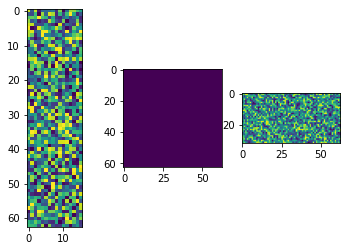

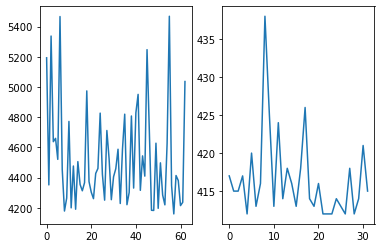

In [6]:
plt.subplot(1, 3, 1)
plt.imshow(np.array(config.input.weights).T)
plt.subplot(1, 3, 2)
plt.imshow(np.array(config.hidden.weights).T)
plt.subplot(1, 3, 3)
plt.imshow(np.array(config.readout.weights).T)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(spec['threshold'])
plt.subplot(1, 2, 2)
plt.plot(spec['threshold_out'])

In [7]:
# - Create a Xylo module with PDM input
dn = False
xmod = XyloSamnaPDM(hdks[0], config, dt=1024e-6, dn_active = dn)

size of hidden neuron count 63
size of output neuron count 32


/home/vleite/Software/rockpool/rockpool/devices/xylo/syns65302/xylo_samna_pdm.py:144: UserWarning: Configured standard BPF and PDM
  warn("Configured standard BPF and PDM")


In [8]:
hdkutils.is_xylo_ready(xmod._read_buffer, xmod._write_buffer)

0

In [9]:
# - Encode a PDM input chirp
from rockpool.devices.xylo.syns65302 import AFESimPDM

from scipy.signal import chirp

pdm_sr = PDM_SAMPLING_RATE
net_dt = 1024e-6
audio_sr = PDM_SAMPLING_RATE # 48e3


afesim_pdm = AFESimPDM.from_specification(
    select_filters=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15),
    spike_gen_mode="divisive_norm",
    # spike_gen_mode="threshold",
    # fixed_threshold_vec = [2**25 for i in range(16)],
    rate_scale_factor=63,
    low_pass_averaging_window=84e-3,
    dn_EPS=32,
    fixed_threshold_vec=None,
    dt=net_dt,
)


# afesim_pdm = AFESimPDM.from_specification(
#     select_filters=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15),
#     # spike_gen_mode="divisive_norm",
#     spike_gen_mode="threshold",
#     fixed_threshold_vec = [2**25 for i in range(16)],
#     rate_scale_factor=63,
#     low_pass_averaging_window=84e-3,
#     dn_EPS=1,
#     # fixed_threshold_vec=None,
#     dt=net_dt,
# )

dur = 200e-3
# dur = 1000e-3

T = int(audio_sr * dur)
f_start = 1000
f_end = 20e3
times = np.arange(0, T) / audio_sr
signal = chirp(times, f_start, T/audio_sr, f_end, method='linear', phi = 90)
# signal = np.sin(2 * np.pi * f_start * times)

__scale = 0.95
out_pdm, state_pdm, rec_pdm = afesim_pdm((signal * __scale, audio_sr))

(9774, 16)


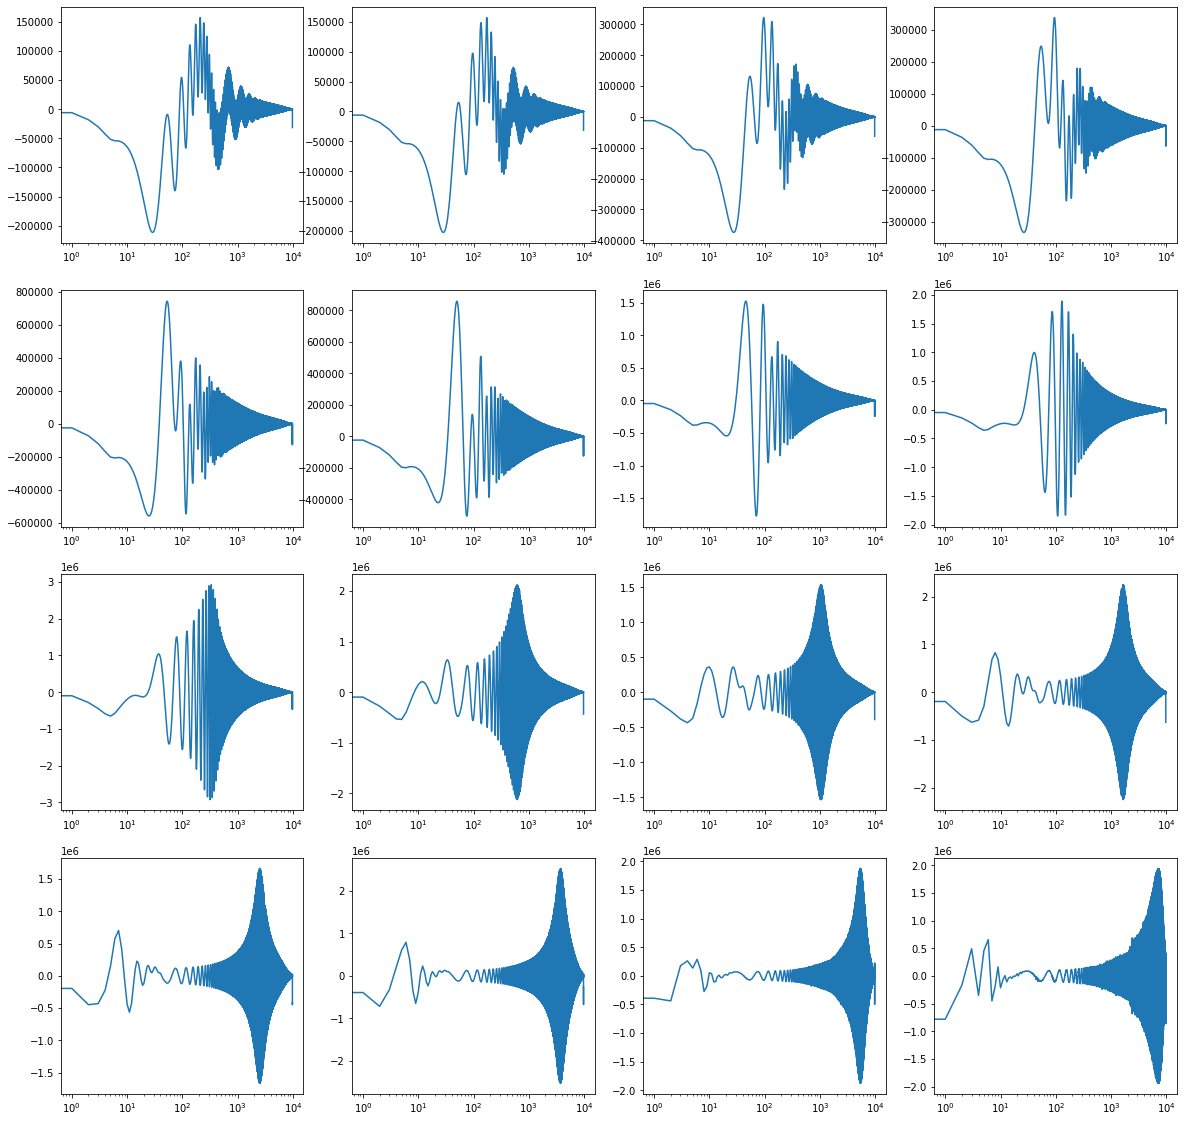

In [10]:
rec_pdm.keys()
filter_out = rec_pdm['1_ChipButterworth_output']
filter_in = rec_pdm['0_PDMADC_output']
plt.figure(figsize=(20, 20))
np.savetxt('filter_in.txt', filter_in, fmt = '%10d')
np.savetxt('filter_out.txt', filter_out, fmt='%10d')
plt.plot(filter_in)
plt.plot(filter_out); plt.legend(np.arange(16))
print(np.shape(filter_out))

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.semilogx(filter_out[:,i])
# np.shape(rec_pdm['1_ChipButterworth_output'])
# rec_pdm['2_DivisiveNormalization']
# np.shape(rec_pdm['0_PDMADC_output'])

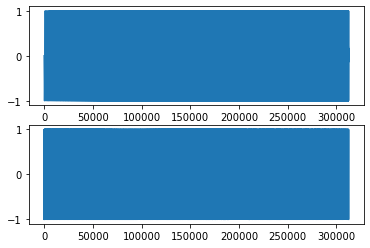

In [11]:
plt.subplot(2, 1, 1)
plt.plot(signal)
plt.subplot(2, 1, 2)
plt.plot(rec_pdm['0_PDMADC']['0_MicrophonePDM_output'])

In [12]:
input_pdm = (rec_pdm['0_PDMADC']['0_MicrophonePDM_output'] + 1) / 2
out, _, rd = xmod(input_pdm, record = True)

/home/vleite/Software/rockpool/rockpool/devices/xylo/syns65302/xylo_samna_pdm.py:226: UserWarning: Input PDM audio trace does not fit evenly into `dt`. Audio will be trimmed at the end of the sample. input size: 312500; PDM_samples_per_dt: 1600.
  warn(


  0%|          | 0/195 [00:00<?, ?it/s]

dbg_stat1   : 0x0


/home/vleite/Software/rockpool/rockpool/devices/xylo/syns65302/xylo_a3_devkit_utils.py:610: UserWarning: You should not provide `count` and `target_timestep` together.
  warn("You should not provide `count` and `target_timestep` together.")


dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1   : 0x0
dbg_stat1 

In [13]:
# np.savetxt('input_pdm.txt',input_pdm, fmt= '%d')

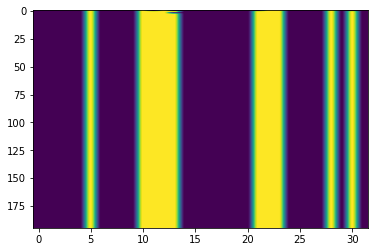

In [14]:
rd.keys()
np.shape(out)
plt.imshow(out, aspect = 'auto')

In [15]:
rd.keys()
print(np.shape(rd['Spikes_in']))

(195, 16)


In [16]:
# AFE_output = rd['Spikes_in']
# AFESim_output = rec_pdm['3_Raster_output']
# print(rec_pdm.keys())
dn_output = rec_pdm['2_DivisiveNormalization_output']

np.savetxt('dn_out_bin.txt', dn_output, fmt='%5d')
# dn_out = dn_output @ np.array([2**i for i in range(16)])

# np.savetxt('dn_out.txt', dn_out, fmt='%04x')
# print(dn_out)
# print(np.shape(dn_out))

# print(np.shape(rec_pdm['2_DivisiveNormalization_output']))
# np.savetxt('AFE_output.txt', AFE_output, fmt='%6d')
# np.savetxt('AFESim_output.txt', AFESim_output, fmt='%6d')

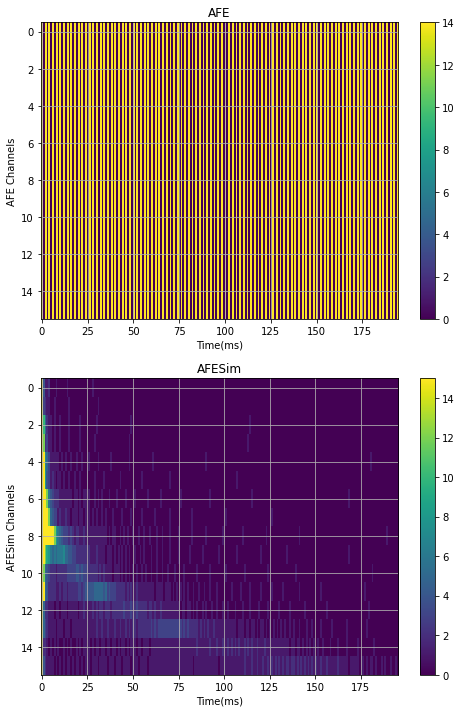

In [17]:
plt.figure(figsize=(8,12))
plt.subplot(211)
plt.imshow(rd['Spikes_in'].T, aspect = 'auto', interpolation='none'); plt.colorbar();  plt.grid(True)
plt.xlabel('Time(ms)'); plt.ylabel('AFE Channels')
plt.title('AFE')
plt.clim([0,14]);


plt.subplot(212)
plt.imshow(rec_pdm['3_Raster_output'].T, aspect ='auto', interpolation='none'); plt.colorbar();  plt.grid(True)
# plt.clim([0,3]);
plt.xlabel('Time(ms)'); plt.ylabel('AFESim Channels')
plt.title('AFESim')
plt.savefig('figs/' + 'dur='+str(dur).replace('.', '_') + 'With_DN_Chirp_afe_vs_afeSim_.png')


[ 130.  125.  205.  205.  310.  310.  510.  580.  990.  885.  690. 1015.
  740. 1065.  780. 1030.]
[7350. 7350. 7350. 7350. 7350. 7350. 7350. 7350. 7350. 7350. 7350. 7350.
 7350. 7350. 7350. 7350.]
[55.53846153846154, 57.8, 34.853658536585364, 34.853658536585364, 22.70967741935484, 22.70967741935484, 13.411764705882353, 11.672413793103448, 6.424242424242424, 7.305084745762712, 9.652173913043478, 6.241379310344827, 8.932432432432432, 5.901408450704225, 8.423076923076923, 6.135922330097087]


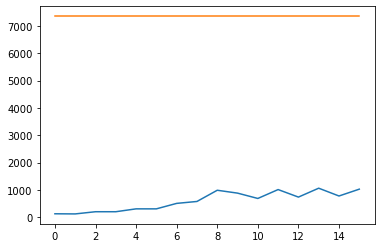

In [18]:
### for AFESim
a = np.sum(rec_pdm['3_Raster_output'].T, axis=1)/dur
print(a)

### for AFE
b = np.sum(rd['Spikes_in'].T, axis=1)/dur
print(b)

plt.plot(a)
plt.plot(b)

print([abs(i-j)/i for i,j in zip(a,b)])

In [19]:
print(config)

xyloAudio3::configuration::XyloConfiguration(operation_mode=OperationMode.Manual, bias_enable=1, enable_hibernation_mode=0, time_resolution_wrap=0, if_input_enable=0, input=xyloAudio3::configuration::InputConfig(weight_bit_shift=0, weights={ 106 -55 60 88 109 123 98 97 40 -70 -107 -33 -37 61 95 -106 -123 -63 -59 -40 -77 -113 105 -110 -101 -40 -39 88 119 -27 -16 -39 -103 -46 55 -3 55 88 10 -20 -82 -14 103 -11 -86 -78 -89 64 -34 -13 -10 -3 -99 -26 51 -11 -25 127 -116 -75 -78 37 45 -59 -72 67 -61 104 -127 116 68 -74 86 62 -22 -18 -14 98 48 71 69 -96 -23 -56 -4 106 -83 117 47 -127 -112 125 127 -3 -66 -104 27 -92 127 102 -67 106 -54 -126 104 10 -100 112 -21 -94 0 89 84 -97 -49 -23 -96 -1 48 127 70 40 102 -77 11 42 103 47 49 -18 -69 -110 -61 -103 -119 -43 127 65 -111 15 115 118 26 -123 53 -47 -30 -41 -61 80 -123 14 -25 127 -83 -96 25 37 -29 2 62 116 -81 -65 19 -9 -32 -16 66 24 -95 -118 66 -127 40 -119 -125 -21 -100 -109 41 62 24 -60 -78 -81 -19 68 35 -109 -127 127 -110 -72 117 -29 -31 -87 -5